In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [9]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax
####################################### Plotting Function
def set_label(ax, xpcent, ypcent, text, fontsize=12, color='k'):
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x2 = xpcent/100.
    x1 = 1.-x2
    y2 = ypcent/100.
    y1 = 1.-y2
    x0 = x1*Xlm[0]+x2*Xlm[1]
    y0 = y1*Ylm[0]+y2*Ylm[1]
    ax.text(x0,y0, text, fontsize=fontsize, color=color)



In [275]:
df = pd.read_csv('fieldGals_simul/DMcalc_u.csv', header=0, dtype=np.float64, names=["logWimx", "0.01", "0.01_err", "0.02", "0.02_err", "0.05", "0.05_err", "0.10", "0.10_err", "0.20", "0.20_err", "0.40", "0.40_err", "0.80", "0.80_err"])

In [285]:
df['0.00'] = 0

df.head(5)

,logWimx,0.01,0.01_err,0.02,0.02_err,0.05,0.05_err,0.10,0.10_err,0.20,0.20_err,0.40,0.40_err,0.80,0.80_err,0.00
0,1.0,0.1062,0.0051,0.1075,0.0076,0.1048,0.0110,0.1040,0.0178,0.1073,0.0262,0.1169,0.0321,-0.1669,0.0400,0
1,1.1,0.1098,0.0047,0.1102,0.0047,0.1087,0.0086,0.1124,0.0137,0.1117,0.0184,0.1244,0.0292,0.0827,0.0404,0
2,1.2,0.1103,0.0050,0.1086,0.0068,0.1103,0.0090,0.1172,0.0119,0.1204,0.0132,0.1375,0.0257,0.3289,0.0408,0
3,1.3,0.1111,0.0039,0.1123,0.0056,0.1150,0.0098,0.1174,0.0150,0.1202,0.0184,0.1511,0.0241,0.5754,0.0413,0
4,1.4,0.1095,0.0050,0.1108,0.0089,0.1096,0.0119,0.1118,0.0158,0.1156,0.0217,0.1718,0.0252,0.8218,0.0420,0


In [286]:
logWimx = np.asarray(df['logWimx'])


In [287]:
def getWe_bound(err):
    
    E = [0, 0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.80]
    for i, e in enumerate(E[:-1]):
        
        if err==e:
            return np.asarray([e,e])
        
        if err>e and err<E[i+1]:
            return np.asarray([e, E[i+1]])
    
    if err==E[i+1]:
        return np.asarray([E[i+1], E[i+1]])
    else: return None     
  
###############################

def getW_bound(logWimx):
    
    W = np.arange(1,3.1,0.1)
    N = len(W)
    for i in range(N-1):
        
        if logWimx==W[i]:
            return np.asarray([logWimx, logWimx])
        
        if logWimx>W[i] and logWimx<W[i+1]:
            return np.asarray([W[i], W[i+1]])
    
    if logWimx==W[i+1]:
        return np.asarray([W[i+1], W[i+1]])
    else: return None   

In [288]:
def intepBias(df, logWimx, err):
    
    Ebound = getWe_bound(err)
    Wbound = getW_bound(logWimx)
    i_Wbound = (Wbound-1)/0.1
    
    
    if err>0.4:
        Ebound = np.asarray([0.2, 0.4])
        
        e00 = df['%.2F'%Ebound[0]][int(i_Wbound[0])]
        if e00<0: e00=0
        e01 = df['%.2F'%Ebound[1]][int(i_Wbound[0])]
        if e01<0: e01=0
        e10 = df['%.2F'%Ebound[0]][int(i_Wbound[1])]
        if e10<0: e10=0
        e11 = df['%.2F'%Ebound[1]][int(i_Wbound[1])]
        if e11<0: e11=0
        
        e20 = (e10-e00)*(logWimx-Wbound[0])/(Wbound[1]-Wbound[0]+1.e-10)+e00
        e40 = (e11-e01)*(logWimx-Wbound[0])/(Wbound[1]-Wbound[0]+1.e-10)+e01
        
        Bias = (err-0.40)*(e40-e20)/0.2+e40
        if Bias<0: Bias = 0 
        
        return Bias
    
    
    sum_w = 0
    sum_e = 0
    for i in [0,1]:
        for j in [0,1]:
            e = df['%.2F'%Ebound[i]][int(i_Wbound[j])]
            dist2 = (logWimx-Wbound[j])**2 + (err-Ebound[i])**2 + 1.E-10
            weight = 1./dist2
            sum_e += e*weight
            sum_w += weight
    Bias = sum_e/sum_w 
    if Bias<0: Bias = 0 
        
    return Bias

In [289]:
print intepBias(df, 1.5, 0.005)

0.05504925372837306


(<matplotlib.axes._subplots.AxesSubplot at 0x7eff17502890>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7eff175b8d50>)

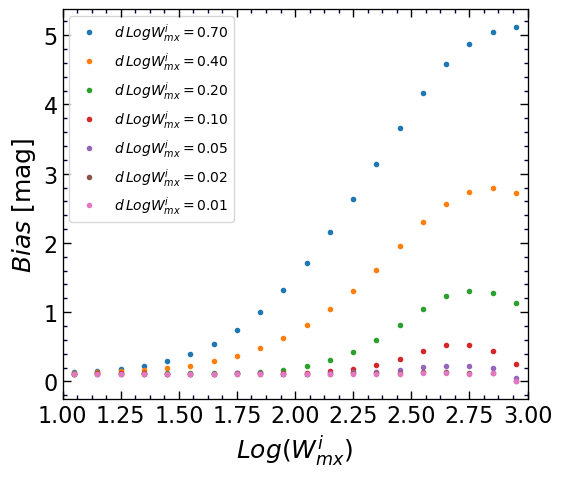

In [281]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.set_xlim(1.0,3.0)
# ax.plot([-12,-24],[0,0], 'k:')

for key in ['0.01', '0.02', '0.05', '0.10', '0.20', '0.40', '0.70'][::-1]:
    
    err = float(key)
    W = np.arange(1.05,3.0,0.1)
    B = W*0
    for i, w in enumerate(W):
        B[i] = intepBias(df, w, err)
    
    ax.plot(W, B, '.', label=r'$d\/LogW^i_{mx} = $'+key)


ax.legend()

# ax.set_ylim(0,0.2)

ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
ax.set_ylabel(r'$Bias$'+ ' [mag]', fontsize=18)

set_axes(ax)